# Data-analysis of 'Optical Tweezer data' on the dynamics of T7 Helicase by using the Ruptures and PWLF library


In [27]:
from nptdms import TdmsFile
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly as py
import ipywidgets as widgets
import scipy as sp
import scipy.optimize
import pwlf
import math
from plotly.subplots import make_subplots
from sympy import coth
from sympy import *
import time 
import ruptures as rpt
from ruptures.metrics import hausdorff
from numba import njit, jit, vectorize
import tabulate
import statsmodels.api as sm
from scipy.stats import _continuous_distns as distns
import copy
import scipy.stats as st

### Define the tWLC model and the FJC model to relate the distance and force of pkYb DNA, to the ratio ssDNA and dsDNA

In [28]:
# parameters for tWLC model: Peter Gross, et al. Nature Physics volume 7, pages731–736(2011)
# dsDNA contour length Lc = 2.85056um; persistent length Lp = 56nm
# the twist rigidity C=440 pN nm2;
# the stretching modulus S=1500 pN;
# the twist–stretch coupling g(F) is given by: g(F) =g0+g1F,where g0=−637 pN nm, g1=17 nm
EEDds,Lc,F,Lp,C,g0,g1,S = symbols('EEDds Lc F Lp C g0 g1 S', real=True)
C = 440
g0= -637
g1 = 17
Lc = 2.85056
Lp = 56
S = 1500
# tWLC model expression:
def tWLC(F):
    EEDds = Lc*(1-0.5*(4.1/(F*Lp))**0.5 + C*F/(-(g0+g1*F)**2 + S*C))
    return (EEDds)

# parameters for FJC model: Smith, S. B., et al. Science 271, 795–799 (1996).
# ssDNA contour length Lss = 4.69504um,
# Kuhn length b = 1.5nm (persistent length is 0.75nm),
# the stretching modulus S=800pN
EEDss,Lss,b,Sss = symbols('EEDss Lss b Sss', real=True)
Lss = 4.69504
b = 1.5
Sss = 800
# FJC model expression:
def FJC(F):
    EEDss  = Lss*(np.cosh(F*b/4.1)/np.sinh(F*b/4.1) - 4.1/(F * b)) * (1 + F/ Sss)
    return (EEDss)

### Exporting the tdms file (from optical tweezers) to pandas.DataFrame

In [29]:
padnaam = "/Users/JeroenvanAsten/Desktop/Bachelorproject/metingen /28 juli/003/20200728-125712 testsample pkyb-DNA (no tail) Helicase #001-003.tdms"
Test_data = TdmsFile.read(padnaam)

In [30]:
Test_data1= Test_data.as_dataframe(time_index=False, absolute_time=False, scaled_data=True)
#print(Test_data1)

### Getting rid of unnecessary data, implement the FJC and tWLC models and making the data more user-friendly

In [31]:
def datacleaner(data):
    ##### marktime and marks data is putted into a dataframe and append to the other dataframe(optional)
    jan= input("Do you want that mark and marktime is added to the data? Type: True       Answer = ")
    if jan == "True":
        data1= data[["/'Marks'/'Time (ms)'","/'Marks'/'Mark #'"]]
        data1 = data1.dropna()
        data1.set_index("/'Marks'/'Time (ms)'",inplace=True)
    else: 
        pass
    
    ##### normal data
    data = data[["/'FD Data'/'Force Channel 0 (pN)'","/'FD Data'/'Time (ms)'","/'FD Data'/'Distance 1 (um)'"]]
    data = data.rename(columns = {"/'FD Data'/'Force Channel 0 (pN)'":"Force (pN)","/'FD Data'/'Distance 1 (um)'":'Distance (um)',"/'FD Data'/'Time (ms)'":"Time (ms)"})
    #data= data["Force (pN)"> input()]
    
    if jan == "True":
        data = data.append(data1, ignore_index = False)
    else:
        pass
    
    data = data.join(tWLC(data["Force (pN)"]).to_frame(name="tWLC"), on=None, how='left', lsuffix='', rsuffix='', sort=False)
    data = data.join(FJC(data["Force (pN)"]).to_frame(name="FJC"), on=None, how='left', lsuffix='', rsuffix='', sort=False)
    
    data['Distance (um)']-= 1.76
    ssDNA_perc =(data['Distance (um)']-data['tWLC'])/(data["FJC"]-data['tWLC'])
    nucleotides_ssDNA= ssDNA_perc * 8393
    data = data.join(nucleotides_ssDNA.to_frame(name = "# of nucleotide unwind"), on=None, how='left', lsuffix='', rsuffix='', sort=False)
    data = data[data["Force (pN)"]> float(input("At what value was the force clamp set (pN)?  "))-3]
    
    return data

In [32]:
cleandata = datacleaner(Test_data1)
#print (cleandata)

Do you want that mark and marktime is added to the data? Type: True       Answer = no
At what value was the force clamp set (pN)?  50


### Example of FJC and tWLC models used to show how the force is related to the distance of pkYB DNA

In [33]:
F_values = np.linspace(1,65, 1000)
FJC_values = FJC(F_values)
tWLC_values = tWLC(F_values)


In [34]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cleandata["Distance (um)"], y=cleandata["Force (pN)"],
                    mode='lines',
                    name='Force (pN)'))

fig.add_trace(go.Scatter(x=FJC_values, y=F_values,
                    mode='lines',
                    name="FJC ssDNA"))

fig.add_trace(go.Scatter(x=tWLC_values, y=F_values,
                    mode='lines',
                    name="tWLC dsDNA"))

fig.update_xaxes(title_text="Distance (um)")
fig.update_yaxes(title_text="Force") 

fig.show()


### Graphical representation of current data

In [35]:
## fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cleandata["Time (ms)"], y=cleandata["Force (pN)"],
                    mode="lines",
                    name='Force (pN)'),secondary_y=False,)

fig.add_trace(go.Scatter(x=cleandata["Time (ms)"], y=cleandata["Distance (um)"],
                    mode='lines',
                    name="Distance raw (um)"),secondary_y=True,)

fig.add_trace(go.Scatter(x=cleandata["Time (ms)"], y=cleandata["# of nucleotide unwind"],
                    mode='lines',
                    name="# of nucleotides ssDNA"),secondary_y=True,)

fig.update_layout(title_text="The unwinding of dsDNA, in the presence of helicase")
fig.update_xaxes(title_text="Time (ms)")
#fig.update_xaxes(tick0=0, dtick=1000)
fig.update_yaxes(title_text="Force",secondary_y=False) 
fig.update_yaxes(title_text="length of ssDNA (nt)",secondary_y=True)


fig.show()

print(" Note: The negative values in the beginning of the measurement are caused by  the on-set of the force clamp.  The DNA (\"distance beads\") and the force clamp or not yet in \ta stable position. Due to this the tWLC and  FJC model will not give realistic values")


 Note: The negative values in the beginning of the measurement are caused by  the on-set of the force clamp.  The DNA ("distance beads") and the force clamp or not yet in 	a stable position. Due to this the tWLC and  FJC model will not give realistic values


### Specyfing time interval of the data to be analysed



In [39]:
### Between what times do you want to fit?
jan= input("Do you want to fit between two times? Type: Yes       Answer = ")

if jan == 'Yes':
    jan1 = int(input("set the time minimum? "))
    jan2 = int(input("set the time maximum? "))
    
    cleandata1 = cleandata[cleandata["Time (ms)"]> jan1]  
    cleandata1 = cleandata1[cleandata1["Time (ms)"]< jan2].reset_index(drop=True)

else:
    cleandata1=cleandata
    
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cleandata1["Time (ms)"], y=cleandata1["Force (pN)"],
                    mode='lines',
                    name='Force'),secondary_y=False,)

fig.add_trace(go.Scatter(x=cleandata1["Time (ms)"], y=cleandata1["Distance (um)"],
                    mode='lines',
                    name='Distance'),secondary_y=True,)

fig.add_trace(go.Scatter(x=cleandata1["Time (ms)"], y=cleandata1["# of nucleotide unwind"],
                    mode='lines',
                    name='# of nucleotide unwind'),secondary_y=True,)

#fig.add_trace(go.Scatter(x=cleandata["Time (ms)"], y=cleandata["Time (ms)"],
                    #mode='markers', name='markers'))

fig.update_layout(title_text="The unwinding of dsDNA, in the presence of helicase")
fig.update_xaxes(title_text="Time (ms)")
fig.update_yaxes(title_text="Force",secondary_y=False) 
fig.update_yaxes(title_text="length of ssDNA",secondary_y=True)
    
fig.show()

Do you want to fit between two times? Type: Yes       Answer = Yes
set the time minimum? 8097
set the time maximum? 159604


In [40]:
### if you want to determine the mean and standard deviation of a flatline

#cleandata1["# of nucleotide unwind"].describe()


### Segmented linear regression with ruptures module

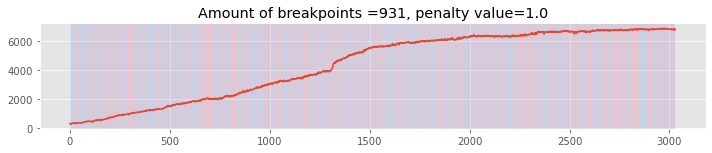

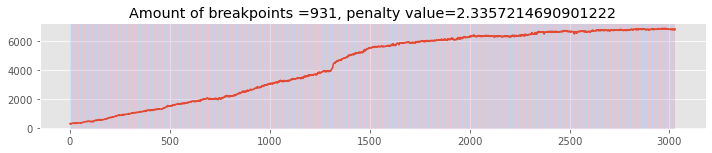

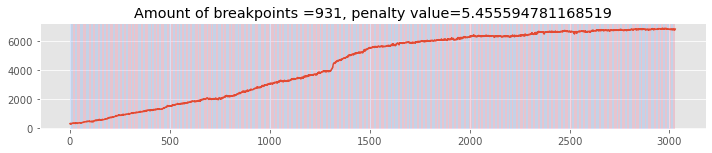

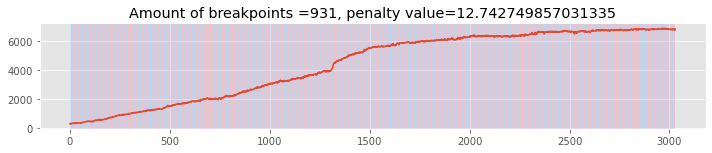

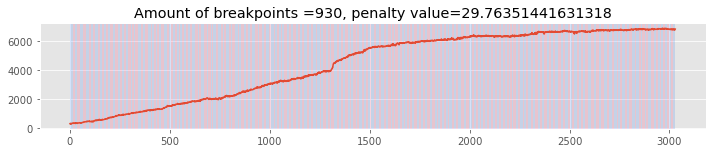

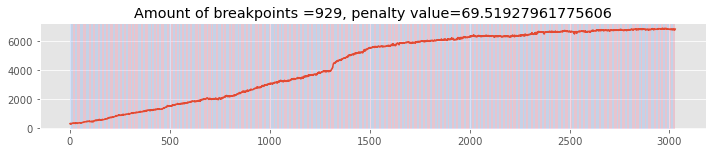

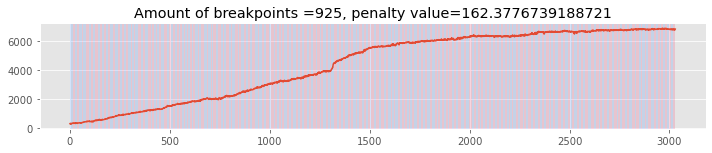

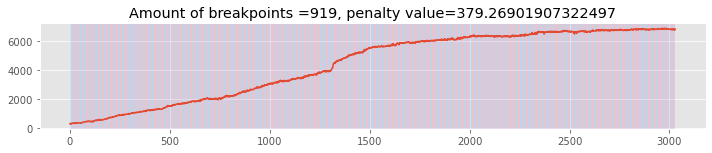

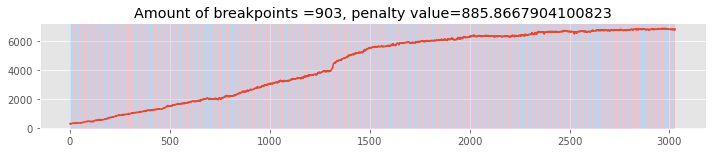

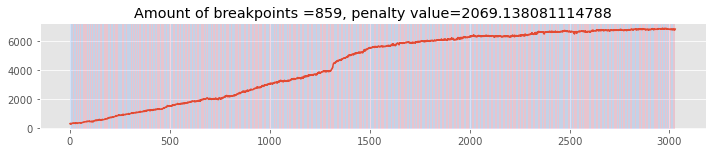

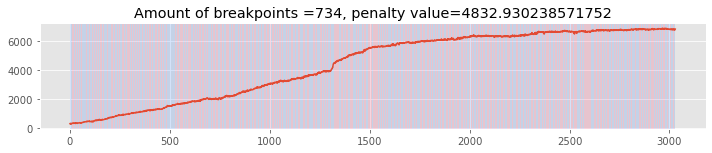

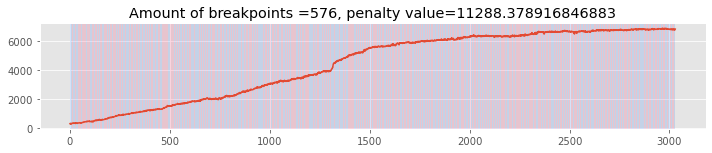

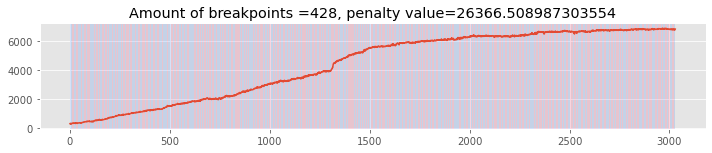

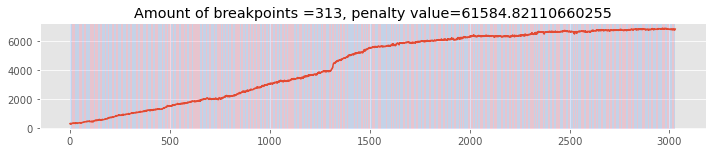

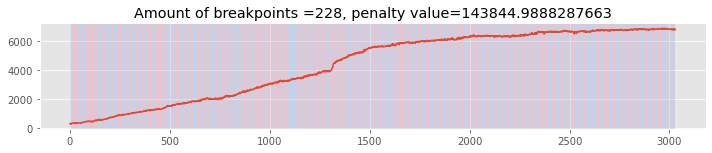

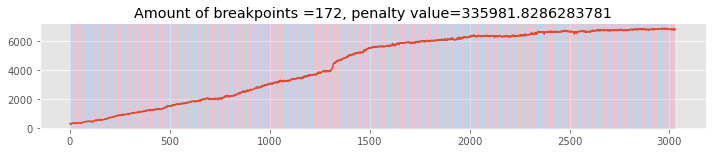

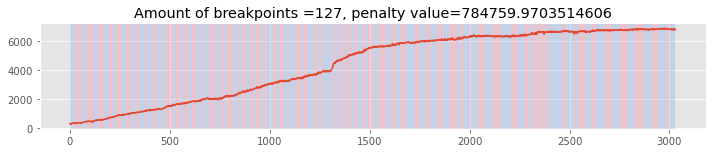

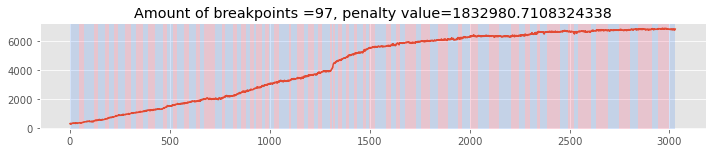

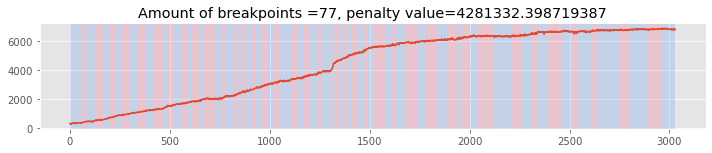

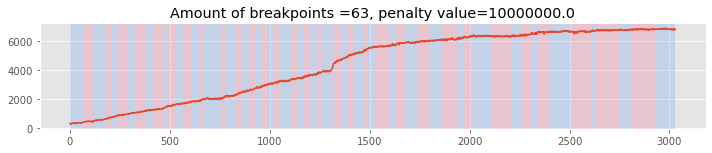

In [49]:
### Finding the best settings
x = cleandata1["Time (ms)"]
y = cleandata1["# of nucleotide unwind"]
signal=cleandata1["# of nucleotide unwind"].values
n=len(signal)


pen_values = np.logspace(0, 7, 20)  # for instance
algo = rpt.Pelt(model="clinear",min_size=1,jump=1).fit(signal)

bkps_list = [algo.predict(pen=pen) for pen in pen_values]

for j,i in enumerate(bkps_list):
    result = i
    rpt.display(signal, result)
    plt.title(f"Amount of breakpoints ={len(result)}, penalty value={pen_values[j]}")
    plt.show
    


Pelt
Computing time to calculate breakpoints 3.256s
Amount of segments is: 127


<function matplotlib.pyplot.show(close=None, block=None)>

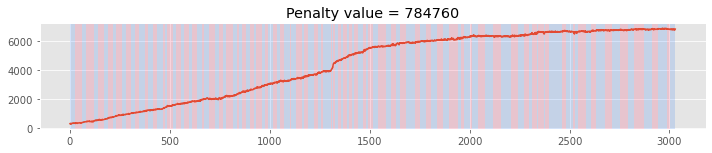

In [50]:
### create variables
x = cleandata1["Time (ms)"]
y = cleandata1["# of nucleotide unwind"]
signal=cleandata1["# of nucleotide unwind"].values
n=len(signal)

###Ruptures programm with search engine, model, and penalty value.

SearchE="Pelt"

#### With penalty values (Pelt)
if  SearchE=="Pelt":
    print("Pelt")
    start_time = time.time()
    #algo = rpt.Pelt(model="clinear", min_size=5, jump= 1).fit(np.column_stack((signal.reshape(-1, 1), x)))
    algo = rpt.Pelt(model="clinear", min_size=1, jump= 1).fit(signal)
    penalty_value = 784760
    result = algo.predict(pen=penalty_value)

#### With breakpoints (dynamic)
if SearchE=="Dynp":
    Print="Dynp"
    start_time = time.time()
    algo = rpt.Dynp(model="linear").fit(np.column_stack((signal.reshape(-1, 1), x)))
    n_bkps=45
    result = algo.predict(n_bkps=n_bkps)
    


print(f"Computing time to calculate breakpoints {(time.time() - start_time):0.3f}s")

#The algo.predict function gives the index numbers of the breakpoints
#These should be converted to x-values and y-values
breakpoint_time=[]
breakpoint_signal=[]

##### The last value is the number of samples, so this can be deleted
breakpoints= np.delete(result, -1)

for i in breakpoints:
    breakpoint_time.append(cleandata1["Time (ms)"].values[i])
    breakpoint_signal.append(cleandata1["# of nucleotide unwind"].values[i])
#### make arrays of lists
breakpoint_time=np.array(breakpoint_time)
breakpoint_signal=np.array(breakpoint_signal)
    
print("Amount of segments is:",int(len(breakpoint_time))+1)


rpt.display(signal, result)
plt.title(f"Penalty value = {penalty_value}")
plt.show

### Define how P-values can be calculated

In [51]:
def p_wlf_values(model):
    #######
    #### The following method is a method designed by the PWLF creator to calculate the P-values, this is not validated
    from scipy import linalg, stats
    n = model.n_data
    #nb = my_pwlf.beta.size + my_pwlf  # This is the number of model parameters that change
    nb = model.beta.size-1 + model.fit_breaks.size - 2
    # you should probally count the number of breakpoints, and the intercept... 
    k = nb - 1
    step_size = 1.0e-4
    A = np.zeros((n, model.n_segments))
    slopes = model.calc_slopes()
    orig_beta = model.beta.copy()
    f0 = model.predict(model.x_data)
        
    for i in range(model.n_segments):
        betas = model.beta[1:i+2]
        n_betas = len(betas)
    # translate the step size in slope into beta change
        betas += (step_size/n_betas)
        model.beta[1:i+2] = betas
    #print(f'Slope {slopes[i]} Slope+FD {np.sum(betas)}')
        f = model.predict(model.x_data)
        A[:, i] = (f - f0) / step_size
    # restore orig betas
        model.beta = orig_beta

    e = f0 - model.y_data
    variance = np.dot(e, e) / (n - nb)
    A2inv = np.abs(linalg.inv(np.dot(A.T, A)).diagonal())
    se = np.sqrt(variance * A2inv)

    # calculate my t-value
    t = slopes / se
    p = 2.0 * stats.t.sf(np.abs(t), df=n - k - 1)

    return p

### PWLF

In [52]:
### Create an numpy.array with all the breakpoint time, 
### so it can be used by the "PWLF" module to calculate, the y-value.
### This is necessary to determine the slope
######### add a x(min) value and x(max) value for ruptures to interpret the breakpoint data
x0 = np.concatenate(([min(x)],breakpoint_time, [max(x)]))
model =pwlf.PiecewiseLinFit(x, y)
breakpoints = model.fit_with_breaks(x0)

#### make pwlf predict what the corresponding y-value will be to the x value
##### *I could maybe also put in the x_value_breakpoints column*
x_hat = np.linspace(x.min(), x.max(), len(cleandata1)+1)
y_hat = model.predict(x_hat)


# Creating the Dataframe that shows all the attributes of the segmented lines
slopes = model.calc_slopes()
x_value_breakpoints = model.fit_breaks
x_value_breakpoints_minus_last=np.delete(x_value_breakpoints, -1)
y_value_breakpoints = model.predict(x_value_breakpoints)
y_value_breakpoints_minus_last=np.delete(y_value_breakpoints, -1)

#Calculate p-values
pvalues= p_wlf_values(model)
pvalues_minus_first =pvalues

interval_list=[]
for i in range(0,len(x_value_breakpoints)-1):
    interval=x_value_breakpoints[i+1]-x_value_breakpoints[i]
    interval_list.append(interval)

deltaY_list=[]
for i in range(0,len(y_value_breakpoints)-1):
    deltaY=y_value_breakpoints[i+1]-y_value_breakpoints[i]
    deltaY_list.append(deltaY)
    

    
x_value_breakpoints_minus_last=np.delete(x_value_breakpoints, -1)

df = pd.DataFrame({'Starting time of the segment':x_value_breakpoints_minus_last,
                       'Slope of the segment':slopes,'Interval of time segment (ms)':interval_list,'Y value of segment':y_value_breakpoints_minus_last,'processivity of the segment':deltaY_list, 'p-value slope':pvalues_minus_first})
df=df.rename_axis('Line #')
t_total = df['Starting time of the segment'].iloc[-1] - df['Starting time of the segment'].iloc[0]



## Creating the GRAPHS WITH ATTRIBUTES

In [56]:
#THE GRAPHS

###add the (force, time) data
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=cleandata1["Time (ms)"], y=cleandata1["Force (pN)"],
                    mode='lines',
                    name='Force (pN)'),secondary_y=False,)

### add the (nucleotide, time) data
fig.add_trace(go.Scatter(x=cleandata1["Time (ms)"], y=cleandata1["# of nucleotide unwind"],
                    mode='lines',
                    name='# of nucleotides ssDNA'),secondary_y=True,)


### add the (linear regressions) data
fig.add_trace(go.Scatter(x=x_hat, y=y_hat,mode='lines',name='segments'),secondary_y=True,)

### add the (yellow dots with hovering) data
fig.add_trace(go.Scatter(
    x=df['Starting time of the segment'],
    y=df['Y value of segment'],
    marker=dict(color="gold", size=5),
    mode="markers",
    name="Attributes of segment(on the right)", customdata=df, hovertemplate='<b>x:%{customdata[0]:.3f} <br><b>y:%{customdata[3]:.3f} <br><b>slope:%{customdata[1]:.6f} <br><b>delta t:%{customdata[2]:.6f} <br><b>p-value slope:%{customdata[5]:.6f}'
    ),secondary_y=True,)

## Scatter that shows where the ruptures module had found the breakpoint, instead of using both ruptures and pwlf

fig.add_trace(go.Scatter(
    x=breakpoint_time,
    y=breakpoint_signal,
    marker=dict(color="blue", size=5),
    mode="markers",
    name="Ruptures"
    ),secondary_y=True,)

## Maybe try with format to automatically change the title to the forceclamp value
fig.update_layout(title_text= "dsDNA seperation, by helicase")
fig.update_xaxes(title_text="Time (ms)")
fig.update_yaxes(title_text="Force",secondary_y=False) 
fig.update_yaxes(title_text="length of ssDNA (nt)",secondary_y=True)

fig.show()
print("The R-sqrt =",model.r_squared())
print("total time is", t_total, "ms")
    

df=copy.deepcopy(df)
pd.set_option('display.max_rows', 10)
df

The R-sqrt = 0.9999057061343256
total time is 150107.0 ms


Starting time of the segment  Slope of the segment  \
Line #                                                       
0                             8148.0              0.023211   
1                             9499.0              0.020015   
2                            11248.0              0.081189   
3                            12198.0              0.011387   
4                            14146.0              0.087804   
...                              ...                   ...   
122                         151756.0             -0.003963   
123                         153656.0              0.020779   
124                         155205.0              0.007658   
125                         157504.0             -0.061642   
126                         158255.0             -0.007474   

        Interval of time segment (ms)  Y value of segment  \
Line #                                                      
0                              1351.0          293.229357   
1                              1749.0          324.587196   
2                               950.0          359.592640   
3                              1948.0          436.722585   
4                               951.0          458.904890   
...                               ...                 ...   
122                            1900.0         6820.745149   
123                            1549.0         6813.215159   
124                            2299.0         6845.401477   
125                             751.0         6863.007898   
126                            1299.0         6816.715078   

        processivity of the segment  p-value slope  
Line #                                              
0                         31.357839       0.060417  
1                         35.005444       0.859490  
2                         77.129945       0.609546  
3                         22.182305       0.956673  
4                         83.502058       0.742367  
...                             ...            ...  
122                       -7.529990       0.998654  
123                       32.186319       0.946861  
124                       17.606421       0.998022  
125                      -46.292820       0.977181  
126                       -9.708705       0.995811  

[127 rows x 6 columns]

### Calculating the Velocity, Pauze and Processivity

In [54]:
#### if p-value is higher than 0.97 the line will be considered as zero.
df2=copy.deepcopy(df)
df2=df2[df2['p-value slope']>0.97] ####dataframe of all pauzes.

###p-value lower than 0.97 and higher than 0 since it is assumed the helicase is not able to move backwards
df3=copy.deepcopy(df)
df3=df3[df3['p-value slope']<0.97]
df3=df3[df3["Slope of the segment"]>0]

####processivity=
processivity = df3["processivity of the segment"].to_frame()
proc_list= []
iterations=0
processivity_value=processivity.iloc[0]
for i in range(len(processivity)):
    if i == len(processivity)-1:
        proc_list.append(processivity_value)
    elif processivity.iloc[i+1].name - processivity.iloc[i].name==1:
        processivity_value=processivity[i-iterations:i+2].sum()
        iterations+=1
        continue
    else:
        proc_list.append(processivity_value)
        
    processivity_value=processivity[i+1:i+2].sum()
    iterations=0

processivity_array=np.array(proc_list)
processivity = pd.DataFrame(processivity_array, columns=['processivity'])


#### pauze duration ### must be tested further
pauze = df2["Interval of time segment (ms)"].to_frame()
pauze_list= []
iterations=0
pauze_value=pauze.iloc[0]
for i in range(len(pauze)):
    if i == len(pauze)-1:
        pauze_list.append(pauze_value)
    elif pauze.iloc[i+1].name - pauze.iloc[i].name==1:
        pauze_value=pauze[i-iterations:i+2].sum()
        iterations+=1
        continue
    else:
        pauze_list.append(pauze_value)
        
    pauze_value=pauze[i+1:i+2].sum()
    iterations=0

    
pauze_array= np.array(pauze_list)
pauze = pd.DataFrame(pauze_array, columns=['Interval of time segment (ms)'])

    
##### Velocity

df4=df3[df3["Slope of the segment"]>0] ### it is assumed the helicase is not able to move backwards
velocity=df4[["Slope of the segment","Interval of time segment (ms)","p-value slope"]]

## Illustrating the determined velocity, processivity and pauze

The mean Velocity is 89.86046622020116 nt/s and the standartd deviation is 117.61850180704756


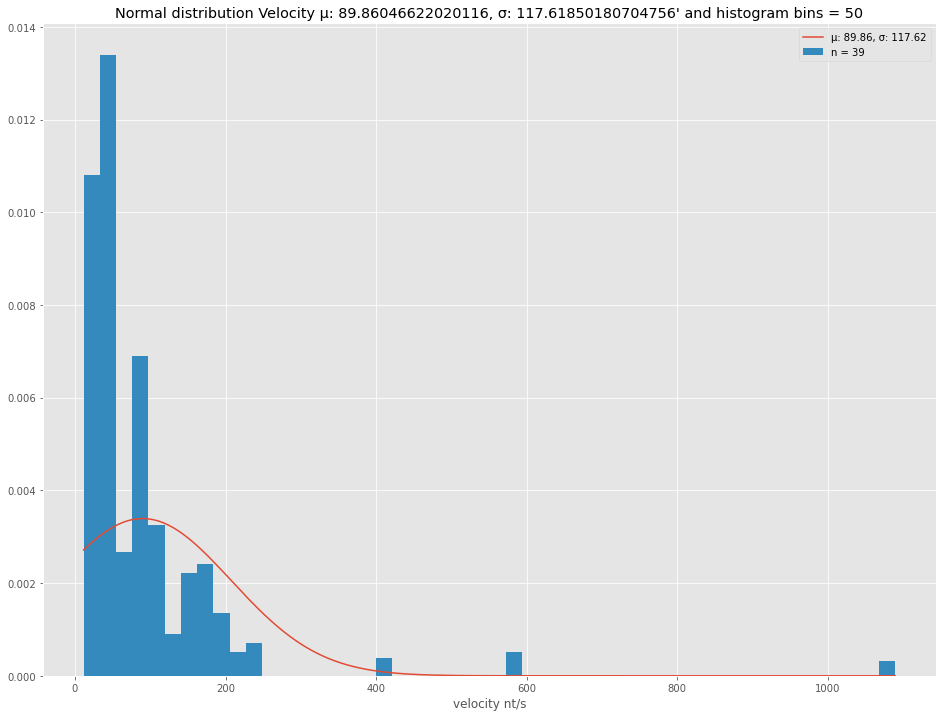

The mean Pauze is 7235.5625 nt/s and the standartd deviation is 7457.784737831559


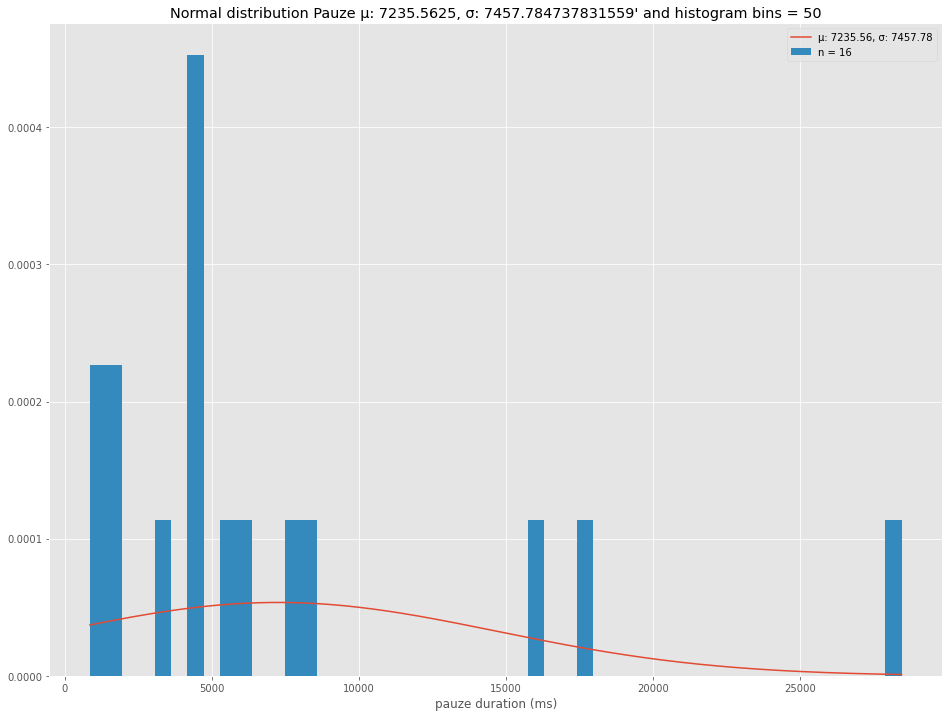

The mean Processivity is 200.1473396680818 nt/s and the standartd deviation is 253.10033321357878


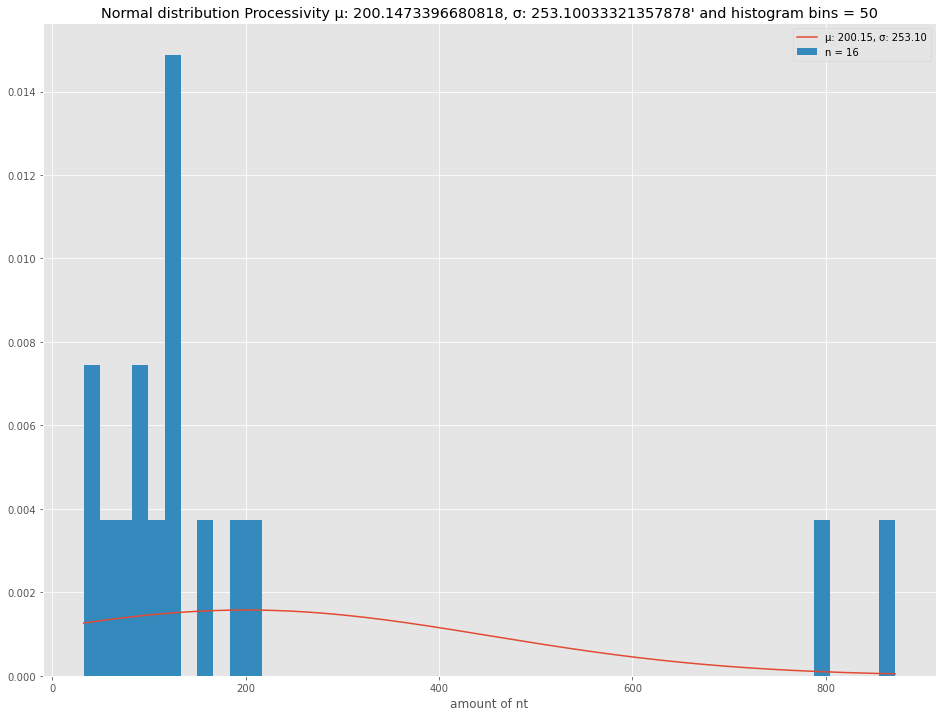

In [55]:
def fit_normal(values, weights):
    
    # prepare (x1000 to go from ms to s)
    values = np.array(values)*1000
    weights = np.array(weights)
        
    # estimate mean
    weights_sum =  weights.sum()
    mean = (values*weights).sum() / weights_sum
   
    # estimate variance
    errors = (values-mean)**2
    std = ((errors*weights).sum() / weights_sum)**0.5
        
    return (mean, std)

for parameter in ['Velocity','Pauze','Processivity']:
    if parameter == 'Velocity':
        mean, std = fit_normal(velocity['Slope of the segment'],velocity["Interval of time segment (ms)"])
        h = np.linspace(min(velocity['Slope of the segment'])*1000,max(velocity['Slope of the segment'])*1000,1000)
        print(f"The mean {parameter} is {mean} nt/s and the standartd deviation is {std}")
        
        xvalue=velocity['Slope of the segment']*1000
        xname="velocity nt/s"
        
        yvalue=velocity["Interval of time segment (ms)"]
        yname='Frequency'
        n=len(velocity)
      
        
    elif parameter == 'Pauze':
        mean = pauze['Interval of time segment (ms)'].mean()
        std= pauze['Interval of time segment (ms)'].std()
        
        print(f"The mean {parameter} is {mean} nt/s and the standartd deviation is {std}")
        
        h = np.linspace(min(pauze['Interval of time segment (ms)']),max(pauze['Interval of time segment (ms)']),1000)
    
        xvalue=pauze['Interval of time segment (ms)']
        xname='pauze duration (ms)'
        
        yvalue=None
        yname=None
        n=len(pauze)

    elif parameter == 'Processivity':
        mean = processivity["processivity"].mean()
        std= processivity["processivity"].std()
        print(f"The mean {parameter} is {mean} nt/s and the standartd deviation is {std}")
        
        h = np.linspace(min(processivity["processivity"]),max(processivity["processivity"]),1000)
        
        xvalue=processivity["processivity"]
        xname='amount of nt'
        
        yvalue=None
        yname=None
        n=len(processivity)
        
    else:
        pass
         
    bins=50
    plt.plot(h, st.norm.pdf(h, mean, std), label=f'μ: {mean:.2f}, σ: {std:.2f}')
    plt.hist(xvalue,bins=bins,weights=yvalue,density=True,label=f"n = {n}")
    plt.title(f"Normal distribution {parameter} μ: {mean}, σ: {std}' and histogram bins = {bins}")
    plt.xlabel(xname)
    plt.legend()
    plt.show()

### This section finds the best probability distribution, this is not evaluated in the thesis

Text(0, 0.5, 'Frequency')

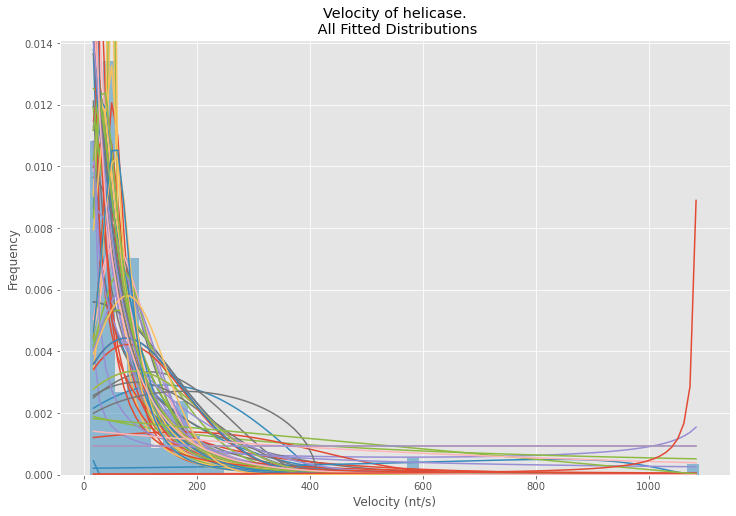

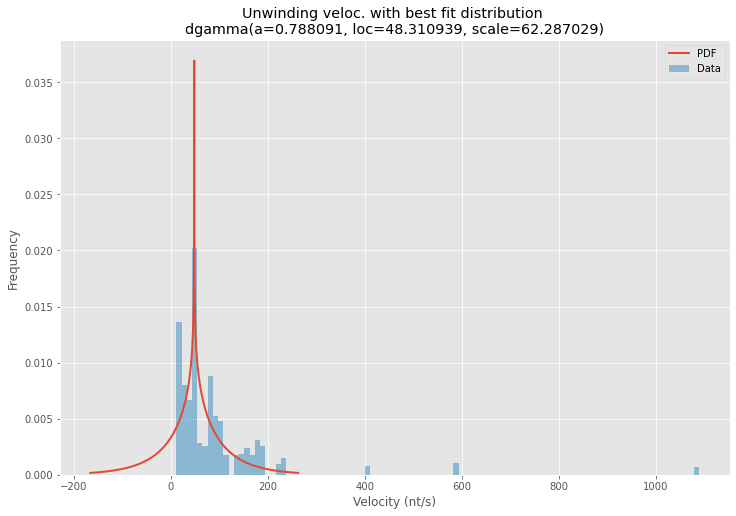

In [57]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

data = np.repeat(velocity["Slope of the segment"]*1000, velocity["Interval of time segment (ms)"]/50)

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=100, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                #print(distribution)
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 100, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Velocity of helicase.\n All Fitted Distributions')
ax.set_xlabel(u'Velocity (nt/s)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=100, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.6f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Unwinding veloc. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Velocity (nt/s)')
ax.set_ylabel('Frequency')